# NPLM Output Analysis

## Imports

In [12]:
import torch 
import h5py
import os 
import sys 
import json

import scipy.stats as stats
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep

sys.path.insert(0, "../src")
from plot_utils     import plot_ref_data, plot_ref_data_reco, plot_loss_history, plot_one_t, plot_two_t, plot_quantiles_evolution
from analysis_utils import compute_df, produce_bins, save_binning, load_binning, find_results, load_results, compute_t_from_loss
from nn_utils       import NPLMnetwork

## Config

In [13]:
hep.style.use(hep.style.CMS)

## Constants

In [14]:
OUTPUT_DIRECTORY = "../output/test/"

# Plotting parameters
FONTSIZE  = 36
FIGSIZE_R = (14, 12)
FIGSIZE   = (14, 10)
PALETTE_1 = [
    "#1f77b4", # 0
    "#4876bf", # 1 
    "#6c74c5", # 2
    "#8f6fc6", # 3
    "#b067c0", # 4
    "#cd5fb4", # 5
    "#e657a3", # 6
    "#f9528d", # 7
    "#ff5474", # 8
    "#ff5d58", # 9
    "#ff6c3a", # 10
    "#ff7f0e", # 11
]
PALETTE_2 = [
    "#494B69", # 0
    "#695D7A", # 1
    "#9F5B72", # 2
    "#D8707C", # 3
    "#FDA85A", # 4
    "#FDCD5A", # 5
]
PALETTE_3 = [
    "midnightblue",   # 0
    "#1f78b4",        # 1
    "lightseagreen",  # 2
    "mediumseagreen", # 3
    "darkseagreen",   # 4
]

PLOT_PATH = "./plots/"
if not os.path.exists(PLOT_PATH):
    os.makedirs(PLOT_PATH)

## Config JSONs

In [4]:
# w_clip = 7.1
# json_path_ref = "/home/ubuntu/NPLM.torch/output/1D_w/sixth/1D/NRef_200000_NBkg_2000_NSig_0_SigLoc_6.4_SigStd_0.16_Epochs_200000_Patience_5000_WClip_7.1_Arch_1_4_1/2024_2_4_20_57_18_764933/config_2024_2_4_20_57_18_764933.json"
# w_clip = 7.6
json_path_ref = "/home/ubuntu/NPLM.torch/output/1D_w/sixth/1D/NRef_200000_NBkg_2000_NSig_0_SigLoc_6.4_SigStd_0.16_Epochs_200000_Patience_5000_WClip_7.6_Arch_1_4_1/2024_2_5_15_29_26_944562/config_2024_2_5_15_29_26_944562.json"
json_path_data = "/home/ubuntu/NPLM.torch/output/1D_w/final/1D/NRef_200000_NBkg_2000_NSig_10_SigLoc_6.4_SigStd_0.16_Epochs_200000_Patience_5000_WClip_7.6_Arch_1_4_1/2024_2_6_10_38_55_854579/config_2024_2_6_10_38_55_854579.json"
# w_clip = 9.0 
# json_path_ref = "/home/ubuntu/NPLM.torch/output/1D_w/sixth/1D/NRef_200000_NBkg_2000_NSig_0_SigLoc_6.4_SigStd_0.16_Epochs_200000_Patience_5000_WClip_9.0_Arch_1_4_1/2024_2_5_21_42_20_280730/config_2024_2_5_21_42_20_280730.json"
# w_clip = 9.2
# json_path_ref = "/home/ubuntu/NPLM.torch/output/1D_w/sixth/1D/NRef_200000_NBkg_2000_NSig_0_SigLoc_6.4_SigStd_0.16_Epochs_200000_Patience_5000_WClip_9.2_Arch_1_4_1/2024_2_6_3_58_54_680884/config_2024_2_6_3_58_54_680884.json"

with open(json_path_ref) as f:
    config_json_ref = json.load(f)

with open(json_path_data) as f:
    config_json_data = json.load(f)

In [33]:
# json_path_ref =  '/home/ubuntu/NPLM.torch/output/1D_w/third/1D/NRef_200000_NBkg_2000_NSig_0_SigLoc_6.4_SigStd_0.16_Epochs_200000_Patience_5000_WClip_7.3_Arch_1_4_1/2024_1_31_20_56_32_456955/config_2024_1_31_20_56_32_456955.json'
# json_path_ref = "/home/ubuntu/NPLM.torch/output/1D_w/second/1D/NRef_200000_NBkg_2000_NSig_0_SigLoc_6.4_SigStd_0.16_Epochs_200000_Patience_5000_WClip_7.0_Arch_1_4_1/2024_1_30_7_51_27_372767/config_2024_1_30_7_51_27_372767.json"
# json_path_ref = "/home/ubuntu/NPLM.torch/output/1D_w/third/1D/NRef_200000_NBkg_2000_NSig_0_SigLoc_6.4_SigStd_0.16_Epochs_200000_Patience_5000_WClip_7.1_Arch_1_4_1/2024_1_31_14_29_9_634113/config_2024_1_31_14_29_9_634113.json"
# json_path_ref = "/home/ubuntu/NPLM.torch/output/1D_w/third/1D/NRef_200000_NBkg_2000_NSig_0_SigLoc_6.4_SigStd_0.16_Epochs_200000_Patience_5000_WClip_6.8_Arch_1_4_1/2024_1_31_20_36_48_921900/config_2024_1_31_20_36_48_921900.json"

# with open(json_path_ref) as f:
#     config_json_ref = json.load(f)
# config_json_ref

## Load NPLM results

In [21]:
ref_dir  = config_json_ref["output_directory"]
data_dir = config_json_data["output_directory"]

ref_losses_names   = find_results(ref_dir, "losses.pth")
ref_weights_names  = find_results(ref_dir, "weights.pth")
data_losses_names  = find_results(data_dir, "losses.pth")
data_weights_names = find_results(data_dir, "weights.pth")

ref_losses, ref_weights   = load_results(ref_dir, ref_losses_names, ref_weights_names)
data_losses, data_weights = load_results(data_dir, data_losses_names, data_weights_names)

## Visualize NPLM results

### Compute test statistics from NPLM results

In [22]:
t_ref  = compute_t_from_loss(ref_losses)
t_data = compute_t_from_loss(data_losses)

t_ref_final  = t_ref[:, -1]
t_data_final = t_data[:, -1]

### Plot BKG only test statistics distribution

In [23]:
ref_dof  = compute_df(config_json_ref["architecture"])
ref_chi2 = stats.chi2(df=ref_dof)

In [24]:
t_ref_bins  = np.arange(0, 50, 5)
t_data_bins = np.arange(0, 80, 5)
xgrid_ref   = np.arange(0, 50, 0.5)
xgrid_data  = np.arange(0, 80, 0.5)

WEIGHT CLIPPING = 7.6


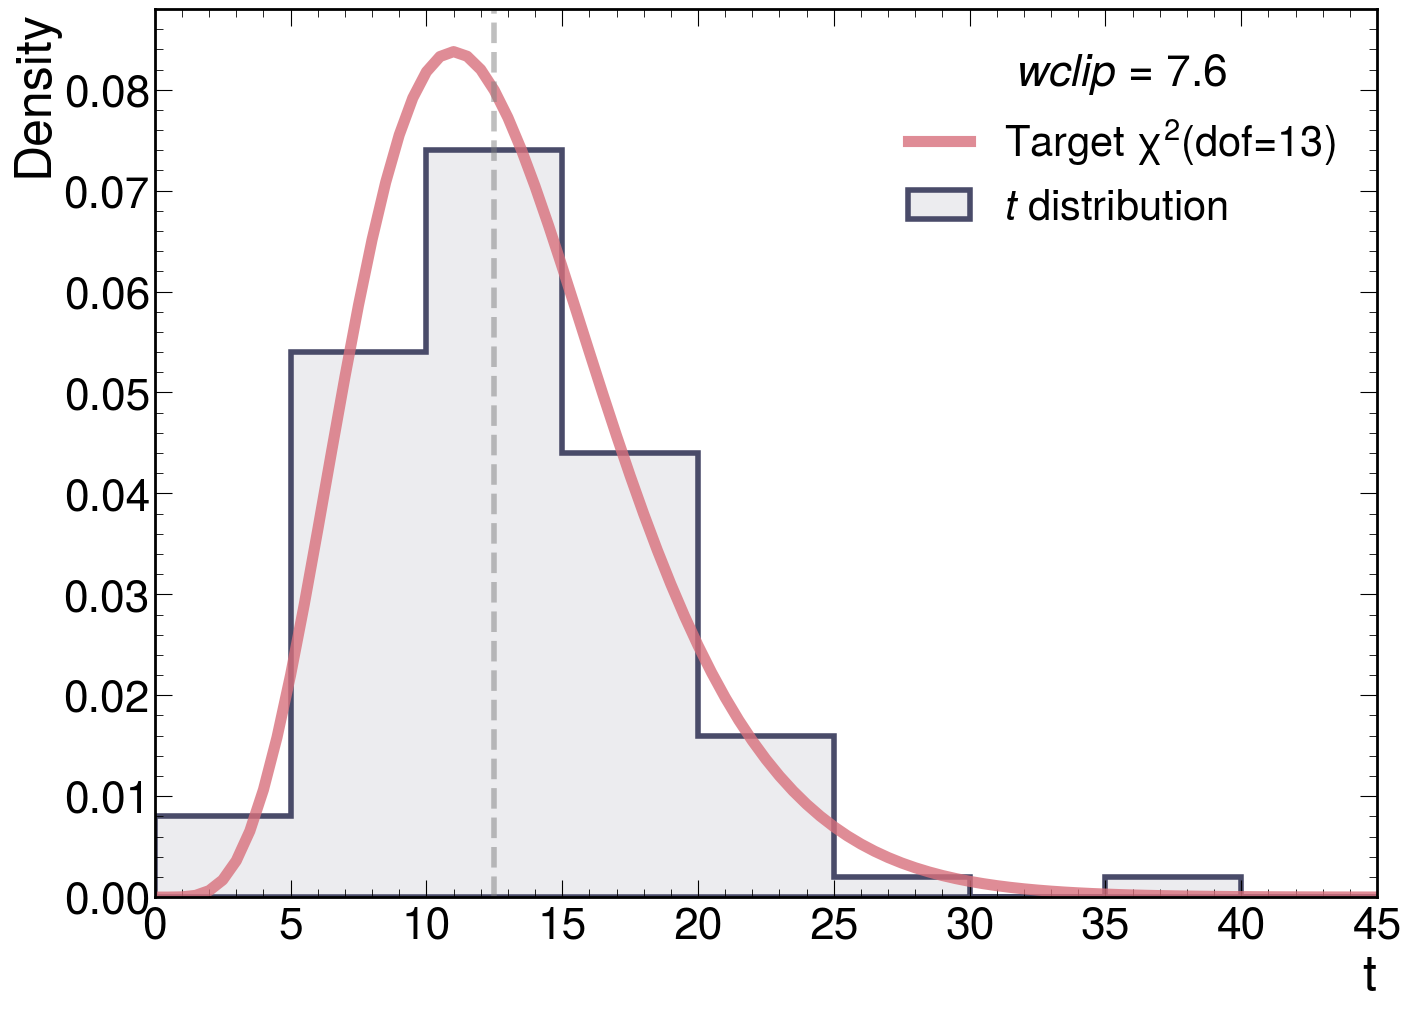

In [25]:
print(f'WEIGHT CLIPPING = {config_json_ref["weight_clipping"]}')
plot_one_t(
    t_distribution  = t_ref_final,
    t_bins          = t_ref_bins,
    chi2            = ref_chi2,
    chi2_grid       = xgrid_ref,
    show_hist       = True,
    show_error      = False,
    compute_rate    = False,
    err_marker      = "o",
    err_markersize  = 10,
    err_capsize     = 5,
    err_elinewidth  = 4,
    err_capthick    = 4,
    err_color       = "black",
    figsize         = FIGSIZE,
    fontsize        = FONTSIZE,
    cms             = False,
    cms_label       = "",
    cms_rlabel      = "",
    hist_ecolor     = (PALETTE_2[0], 1.0),
    hist_fcolor     = (PALETTE_2[0], 0.1),
    chi2_color      = (PALETTE_2[3], 0.8),
    hist_lw         = 4,
    chi2_lw         = 8,
    hist_type       = "stepfilled",
    hist_label      = "$\it{t}$ distribution",
    chi2_label      = "Target $\chi^2$(dof=%i)"%(ref_dof),
    xlabel          = r"$t$",
    ylabel          = "Density",
    show_plot       = True,
    save_plot       = False,
    plot_name       = "t_distribution",
    plot_path       = PLOT_PATH,
    plot_format     = "png",
    return_fig      = False,
    plot_w          = True,
    wclip           = config_json_ref["weight_clipping"],
)


### Plot quantiles evolution over training

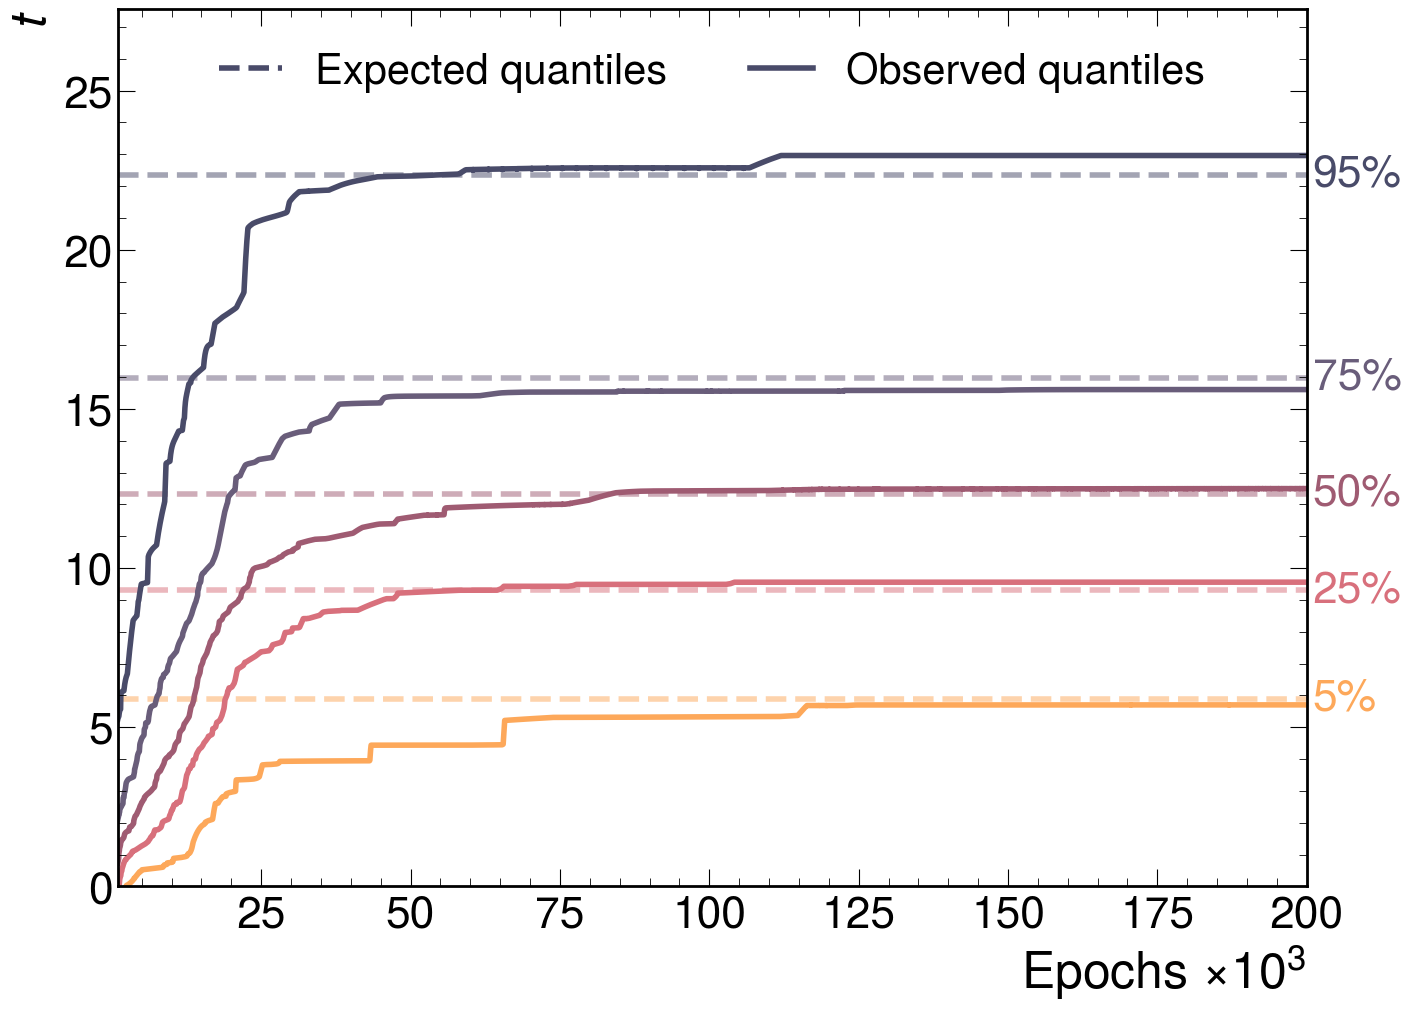

In [31]:
quantile_list   = [0.95,  0.75,  0.5,   0.25,  0.05]
quantile_labels = ["95%", "75%", "50%", "25%", "5%"]

plot_quantiles_evolution(
    t_history       = t_ref,
    quantile_list   = quantile_list,
    quantile_labels = quantile_labels,
    chi2            = ref_chi2,
    obs_alpha       = 1.0,
    th_alpha        = 0.5,
    epochs_init     = 1000,
    epochs_norm     = 1e3,
    figsize         = FIGSIZE,
    fontsize        = FONTSIZE,
    palette         = PALETTE_2,
    lw              = 4,
    cms             = False,
    cms_label       = "",
    cms_rlabel      = "",
    grid            = False,
    xlabel          = r"Epochs $\times 10^3$",
    ylabel          = "$\it{t}$",
    show_plot       = True,
    save_plot       = True,
    plot_name       = "loss_history_w" + str({config_json_ref["weight_clipping"]}),
    plot_path       = PLOT_PATH,
    plot_format     = "png",
    return_fig      = False,
    # plot_w          = True,
    # wclip           = config_json_ref["weight_clipping"],
)

### Compatibility $\mathcal{R}$ vs pseudo-$\mathcal{R}$

In [26]:
from scipy import stats
from scipy.integrate import quad
from scipy.special import erfinv

t_obs = np.median(t_ref_final)
pdf_values = ref_chi2.pdf(xgrid_ref)
# p_val_def, _ = quad(lambda x: ref_chi2.pdf(x), t_obs, np.inf)
p_val = 1 - ref_chi2.cdf(t_obs)

Z = np.sqrt(2) * erfinv(1 - p_val)

print(f'p-value: {p_val}')
print(f'Z-score: {Z}\n')

cdf_values  = ref_chi2.cdf(xgrid_ref)
cdf_t_distr = np.cumsum(t_ref_final)

ks_statistic, ks_p_value = stats.kstest(t_ref_final, "chi2", args=(13,))

print(f"KS Statistic: {ks_statistic}")
print(f"P-value: {ks_p_value}")

p-value: 0.48739378766115826
Z-score: 0.6944599837281911

KS Statistic: 0.05312926958092612
P-value: 0.925997609764426


### Plot BKG and BKG+SIG test statistics distributions

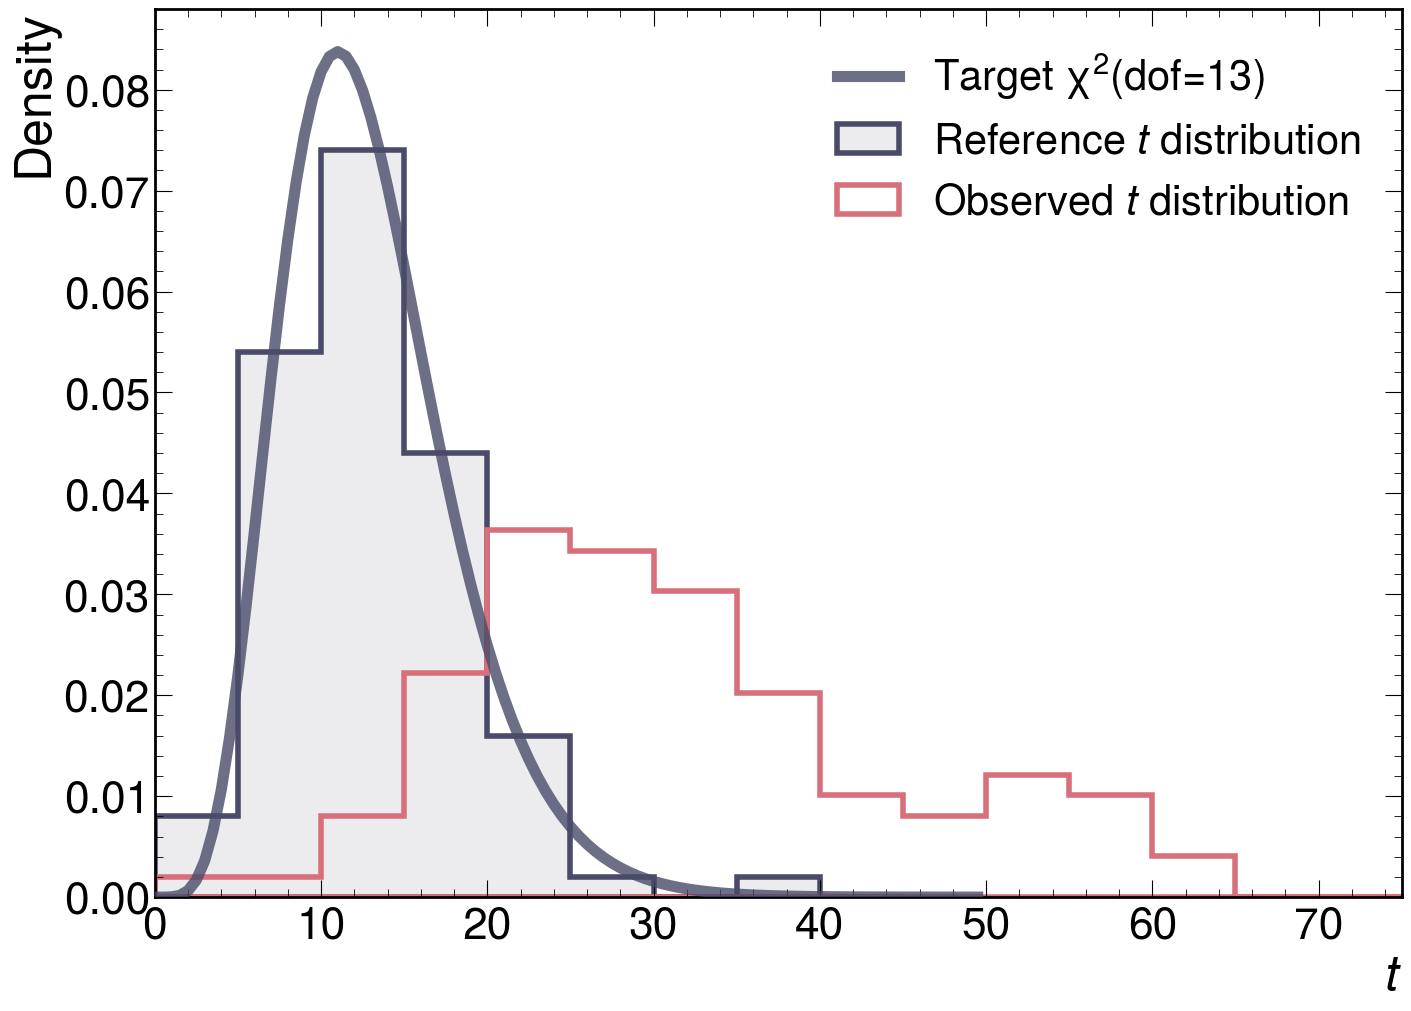

In [27]:
plot_two_t(
    t_distribution_1  = t_ref_final,
    t_bins_1          = t_ref_bins,
    t_distribution_2  = t_data_final,
    t_bins_2          = t_data_bins,
    chi2              = ref_chi2,
    chi2_grid         = xgrid_ref,
    show_error_1      = False,
    show_error_2      = False,
    show_hist_1       = True,
    show_hist_2       = True,
    compute_rate_1    = False,
    compute_rate_2    = True,
    err_marker_1      = "o",
    err_marker_2      = "o",
    err_markersize_1  = 10,
    err_markersize_2  = 10,
    err_capsize_1     = 5,
    err_capsize_2     = 5,
    err_elinewidth_1  = 4,
    err_elinewidth_2  = 4,
    err_capthick_1    = 4,
    err_capthick_2    = 4,
    figsize           = FIGSIZE,
    fontsize          = FONTSIZE,
    cms               = False,
    cms_label         = "",
    cms_rlabel        = "",
    hist_ecolor_1     = (PALETTE_2[0], 1),
    hist_ecolor_2     = (PALETTE_2[3], 1),
    hist_fcolor_1     = (PALETTE_2[0], 0.1),
    hist_fcolor_2     = (PALETTE_2[3], 0),
    err_ecolor_1      = (PALETTE_2[0], 1),
    err_ecolor_2      = (PALETTE_2[3], 1),
    chi2_color        = (PALETTE_2[0], 0.8),
    hist_lw_1         = 4,
    hist_lw_2         = 4,
    chi2_lw           = 8,
    hist_type_1       = "stepfilled",
    hist_type_2       = "stepfilled",
    hist_label_1      = "Reference $\it{t}$ distribution",
    hist_label_2      = "Observed $\it{t}$ distribution",
    chi2_label        = "Target $\chi^2$(dof=%i)"%(ref_dof),
    xlabel            = "$\it{t}$",
    ylabel            = "Density",
    show_plot         = True,
    save_plot         = False,
    plot_name         = "t_distribution",
    plot_path         = PLOT_PATH,
    plot_format       = "png",
    return_fig        = False
)

### Compatibility $\mathcal{R}$ vs $\mathcal{D}$

In [34]:
from scipy import stats
from scipy.integrate import quad
from scipy.special import erfinv

t_obs = np.median(t_data_final)
pdf_values = ref_chi2.pdf(xgrid_ref)
p_val_def, _ = quad(lambda x: ref_chi2.pdf(x), t_obs, np.inf)
p_val = 1 - ref_chi2.cdf(t_obs)

# print(p_val_def)
# print(p_val)

Z = np.sqrt(2) * erfinv(1 - p_val)

print(f'p-value: {p_val}')
print(f'Z-score: {Z}')

p-value: 0.0051950742011536155
Z-score: 2.794682294135305


# 5D

In [5]:
json_path_ref = "/home/ubuntu/NPLM.torch/output/5D/first/5D/NRef_1000000_NBkg_200000_NSig_0_NP_Z_Epochs_500000_Patience_5000_WClip_2.6_Arch_5_5_5_5_1/2024_2_8_16_41_17_44049/config_2024_2_8_16_41_17_44049.json"
# json_path_ref = "/home/ubuntu/NPLM.torch/output/5D/first/5D/NRef_40000_NBkg_8000_NSig_0_NP_Z_Epochs_300000_Patience_5000_WClip_4.0_Arch_5_5_5_5_1/2024_2_7_17_44_58_591162/config_2024_2_7_17_44_58_591162.json"
# json_path_data = "/home/ubuntu/NPLM.torch/output/1D_w/final/1D/NRef_200000_NBkg_2000_NSig_10_SigLoc_6.4_SigStd_0.16_Epochs_200000_Patience_5000_WClip_7.6_Arch_1_4_1/2024_2_6_10_38_55_854579/config_2024_2_6_10_38_55_854579.json"
json_path_ref = "/home/ubuntu/NPLM.torch/output/5D/first/5D/NRef_100000_NBkg_20000_NSig_0_NP_Z_Epochs_500000_Patience_5000_WClip_2.6_Arch_5_5_5_5_1/2024_2_13_17_41_3_988147/config_2024_2_13_17_41_3_988147.json"
with open(json_path_ref) as f:
    config_json_ref = json.load(f)

# with open(json_path_data) as f:
#     config_json_data = json.load(f)



In [10]:
ref_dir  = config_json_ref["output_directory"]
# data_dir = config_json_data["output_directory"]
ref_losses_names   = find_results(ref_dir, "losses.pth")
ref_weights_names  = find_results(ref_dir, "weights.pth")
# data_losses_names  = find_results(data_dir, "losses.pth")
# data_weights_names = find_results(data_dir, "weights.pth")
ref_losses, ref_weights   = load_results(ref_dir, ref_losses_names, ref_weights_names)
# data_losses, data_weights = load_results(data_dir, data_losses_names, data_weights_names)
t_ref  = compute_t_from_loss(ref_losses)
# t_data = compute_t_from_loss(data_losses)
t_ref_final  = t_ref[:, -1]
# t_data_final = t_data[:, -1]
ref_dof  = compute_df(config_json_ref["architecture"])
ref_chi2 = stats.chi2(df=ref_dof)

NameError: name 'config_json_ref' is not defined

In [7]:
t_ref_bins  = np.arange(40, 400, 20)
t_data_bins = np.arange(40, 400, 20)
xgrid_ref   = np.arange(0, 400, 1)
xgrid_data  = np.arange(0, 400, 1)

WEIGHT CLIPPING = 2.6


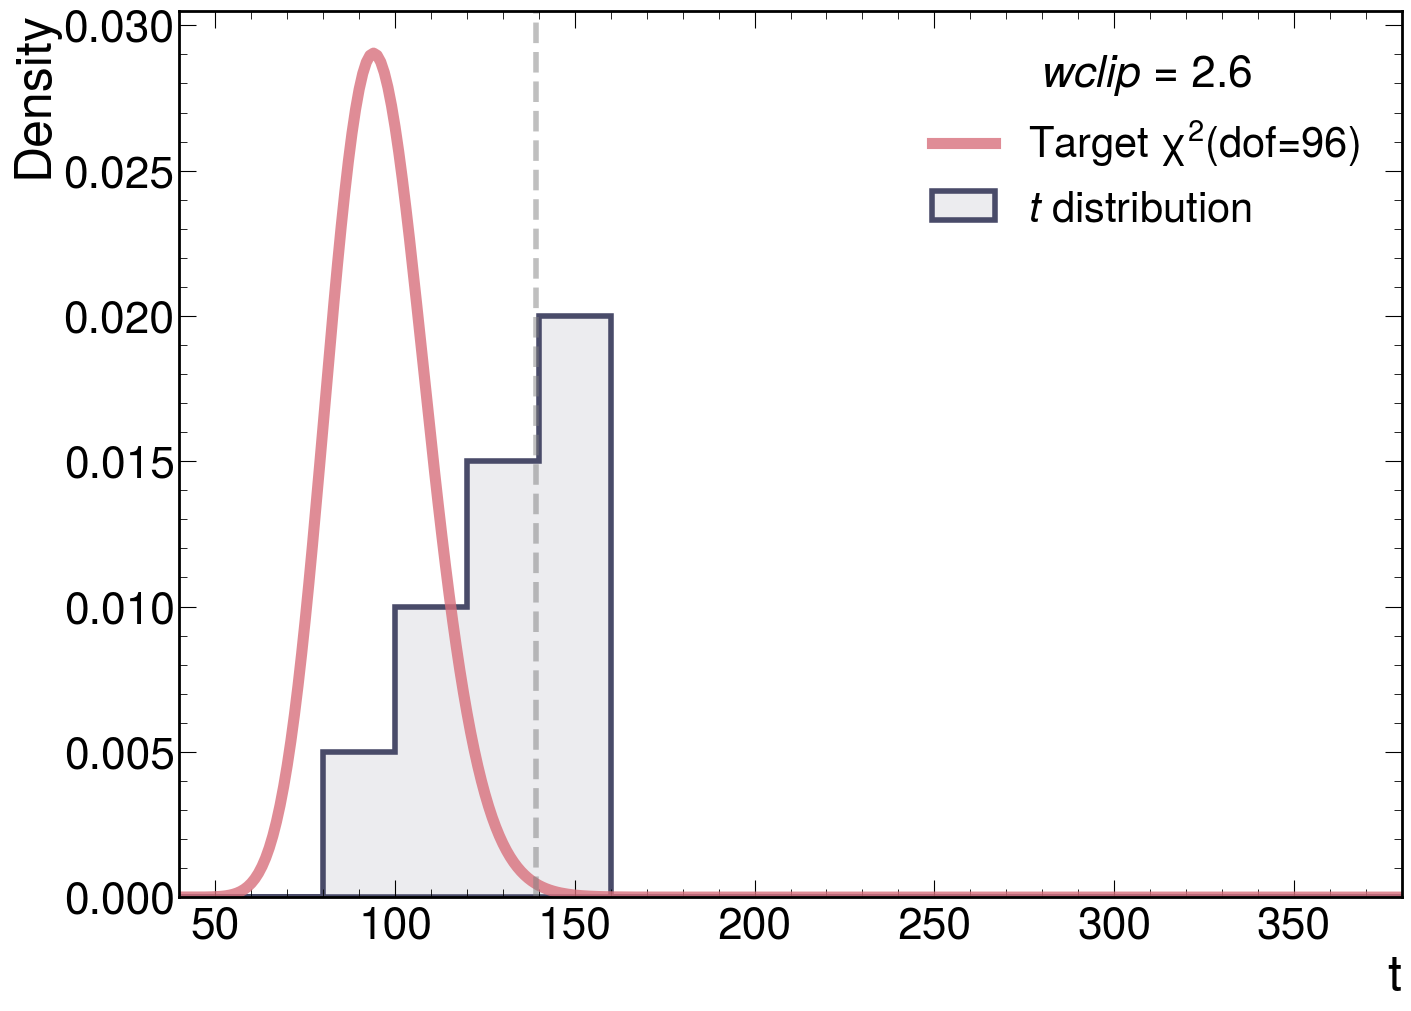

In [57]:
print(f'WEIGHT CLIPPING = {config_json_ref["weight_clipping"]}')
plot_one_t(
    t_distribution  = t_ref_final,
    t_bins          = t_ref_bins,
    chi2            = ref_chi2,
    chi2_grid       = xgrid_ref,
    show_hist       = True,
    show_error      = False,
    compute_rate    = False,
    err_marker      = "o",
    err_markersize  = 10,
    err_capsize     = 5,
    err_elinewidth  = 4,
    err_capthick    = 4,
    err_color       = "black",
    figsize         = FIGSIZE,
    fontsize        = FONTSIZE,
    cms             = False,
    cms_label       = "",
    cms_rlabel      = "",
    hist_ecolor     = (PALETTE_2[0], 1.0),
    hist_fcolor     = (PALETTE_2[0], 0.1),
    chi2_color      = (PALETTE_2[3], 0.8),
    hist_lw         = 4,
    chi2_lw         = 8,
    hist_type       = "stepfilled",
    hist_label      = "$\it{t}$ distribution",
    chi2_label      = "Target $\chi^2$(dof=%i)"%(ref_dof),
    xlabel          = r"$t$",
    ylabel          = "Density",
    show_plot       = True,
    save_plot       = False,
    plot_name       = "t_distribution",
    plot_path       = PLOT_PATH,
    plot_format     = "png",
    return_fig      = False,
    plot_w          = True,
    wclip           = config_json_ref["weight_clipping"],
)


In [43]:
timing = np.array((5331.4884469509125,
                5075.978938102722,
                4795.943756818771,
                8305.745493888855,
                5058.158457517624,
                4912.563215970993,
                5021.674886703491,
                4882.236337423325,
                4861.925380468368,
                4910.300239086151))

print(f'({timing.mean()/60:.1f} \pm {timing.std()/60:.1f}) mins' )

(88.6 \pm 16.8) mins


## Gaia

In [15]:
timing_gaia = np.array((
    
    4933.472449541092,
    4484.754745721817,
    4788.920588731766,
    4934.492271661758,
    4815.106371641159,
    4754.722471952438,
    4946.091267108917,
    4883.8006093502045,
    4537.580480337143,
    4559.75444316864
))
print(f'({timing_gaia.mean()/60:.1f} \pm {timing_gaia.std()/60:.1f}) mins' )


(79.4 \pm 2.8) mins


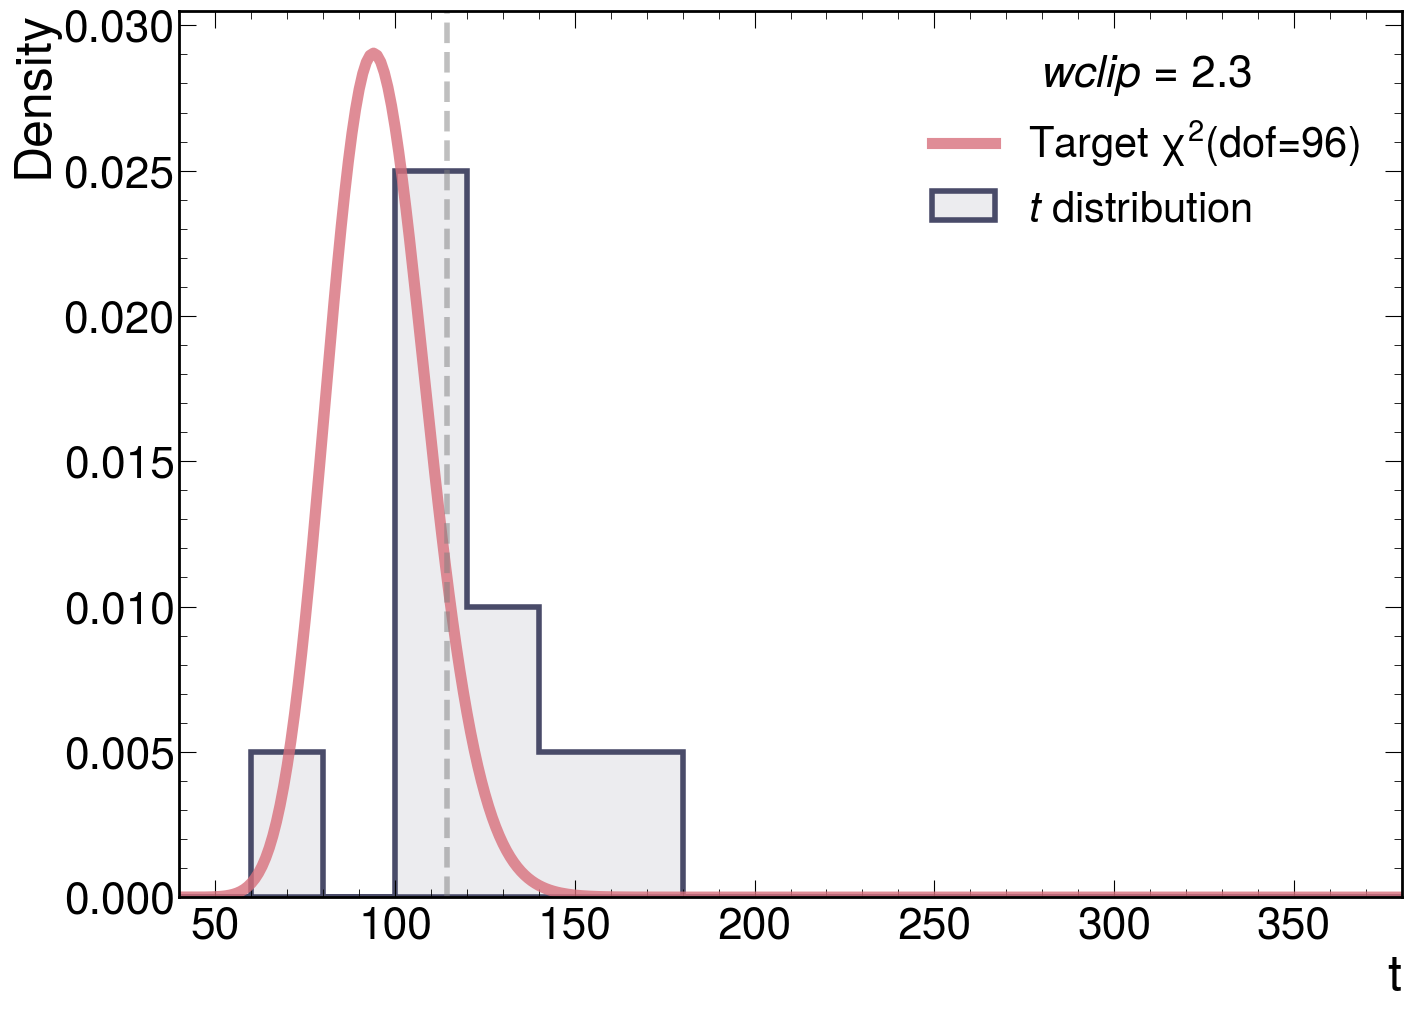

In [18]:
t_list = [163.558701, 110.585983, 150.397552, 130.076294, 103.131935, 114.537117, 114.174927, 66.066734, 120.987740, 100.932220]
ref_chi2 = stats.chi2(df=96)

plot_one_t(
    t_distribution  = t_list,
    t_bins          = t_ref_bins,
    chi2            = ref_chi2,
    chi2_grid       = xgrid_ref,
    show_hist       = True,
    show_error      = False,
    compute_rate    = False,
    err_marker      = "o",
    err_markersize  = 10,
    err_capsize     = 5,
    err_elinewidth  = 4,
    err_capthick    = 4,
    err_color       = "black",
    figsize         = FIGSIZE,
    fontsize        = FONTSIZE,
    cms             = False,
    cms_label       = "",
    cms_rlabel      = "",
    hist_ecolor     = (PALETTE_2[0], 1.0),
    hist_fcolor     = (PALETTE_2[0], 0.1),
    chi2_color      = (PALETTE_2[3], 0.8),
    hist_lw         = 4,
    chi2_lw         = 8,
    hist_type       = "stepfilled",
    hist_label      = "$\it{t}$ distribution",
    chi2_label      = "Target $\chi^2$(dof=%i)"%(96),
    xlabel          = r"$t$",
    ylabel          = "Density",
    show_plot       = True,
    save_plot       = False,
    plot_name       = "t_distribution",
    plot_path       = PLOT_PATH,
    plot_format     = "png",
    return_fig      = False,
    plot_w          = True,
    wclip           = 2.3,
)
